### Jupyter Notebook "3-Kmeans_&_KNN":  
* 8-Imports.
     * 8.1-Import librerias necesarias.
     * 8.2-Import de DFs del Jupyter Notebook anterior.
     
* 9-Preparando los datos para K-means y KNN.
    * 9.1-Detección de outliers.

* 10-K-means.

* 11-KNN.
    * 11.1-Esquema 1: Train Set, Test Set & Validation Set.
    * 11.2-Esquema 2: Cross Validation.

* 12-Clasificando nuevas muestras.
    * 12.1-Candidato 'SecuritySpecialist_Denis Banik'.
    * 12.2-Posición 'HCM Consultant 2'.

### 8-Imports.

### 8.1-Import librerias necesarias.

In [31]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as  plt
#%matplotlib inline
import string
import math

#K-means:
from sklearn.cluster import KMeans
import numpy as np
from pandas import DataFrame

#Elbow K-means:
from sklearn import metrics 
from scipy.spatial.distance import cdist

#KNN:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection  import cross_val_score  #Anteriormente era sklearn.cross_validation (deprecado)

### 8.2-Import de DFs del Jupyter Notebook anterior.

In [32]:
df_compar_cand_jobs_loaded = pd.read_pickle('DF_Exportado_Jobs_And_Candidates_tfidf_cosine_and_wmd')
df_compar_cand_jobs_loaded.shape

(3131, 8)

In [33]:
df_compar_cand_jobs_loaded

,Candidate_Name,clean_Content_CV,tokens_Content_CV,Job_Title,clean_Job_Description,tokens_Job_Description,tfidf_cosine,WMD
0,DataScientist_Karla_Lewis,data_scientist brooklyn ny data_scientist grub...,"[data_scientist, brooklyn, ny, data_scientist,...",Data Scientist,master_degree stem field including_limited com...,"[master_degree, stem, field, including_limited...",0.043,0.517
1,DataScientist_Karla_Lewis,data_scientist brooklyn ny data_scientist grub...,"[data_scientist, brooklyn, ny, data_scientist,...",Data Scientist 2,reporting director data analytics senior data_...,"[reporting, director, data, analytics, senior,...",0.111,0.525
2,DataScientist_Karla_Lewis,data_scientist brooklyn ny data_scientist grub...,"[data_scientist, brooklyn, ny, data_scientist,...",HCM Consultant,oracle cloud hcm absence consultant responsibl...,"[oracle, cloud, hcm, absence, consultant, resp...",0.018,0.501
3,DataScientist_Karla_Lewis,data_scientist brooklyn ny data_scientist grub...,"[data_scientist, brooklyn, ny, data_scientist,...",HCM Consultant 2,peoplesoft oracle_eb implementation support hc...,"[peoplesoft, oracle_eb, implementation, suppor...",0.013,0.500
4,DataScientist_Karla_Lewis,data_scientist brooklyn ny data_scientist grub...,"[data_scientist, brooklyn, ny, data_scientist,...",Machine Learning Engineer,leveraging_latest machine deep_learning techni...,"[leveraging_latest, machine, deep_learning, te...",0.050,0.518
...,...,...,...,...,...,...,...,...
3126,Neha Mugghala,sourya senior java_ee developer working variou...,"[sourya, senior, java_ee, developer, working, ...",Test Lead / Test Manager,location_atlanta gajob title test lead manager...,"[location_atlanta, gajob, title, test, lead, m...",0.026,0.485
3127,Neha Mugghala,sourya senior java_ee developer working variou...,"[sourya, senior, java_ee, developer, working, ...",Principal Application Analyst-Supply Chain Lawson,vanderhouwen_job like find please join talent ...,"[vanderhouwen_job, like, find, please, join, t...",0.106,0.516
3128,Neha Mugghala,sourya senior java_ee developer working variou...,"[sourya, senior, java_ee, developer, working, ...",Messaging Administrator,genesis actively_seeking messaging administrat...,"[genesis, actively_seeking, messaging, adminis...",0.063,0.512
3129,Neha Mugghala,sourya senior java_ee developer working variou...,"[sourya, senior, java_ee, developer, working, ...","Java Architect - Denver, CO - Fulltime",client healthcare software industry seeking ja...,"[client, healthcare, software, industry, seeki...",0.081,0.507


## 9-Preparando los datos para K-means y KNN.

Eliminaremos 1 CV y 1 Job Description (un total de 131 filas) de nuestro DF. Estos datos los utilizaremos en '12-Clasificando nuevas muestras' para predecir con KNN utilizando dichos Candidatos y Descripciones de Puestos que tienen los valores de WMD y Cosine SImilarity calculados, pero estos datos no fueron vistos por los modelos de K-means ni KNN.  

De esta manera nos quedará el DF con 3000 filas / puntos para entrenar K-means y KNN.
Y 131 filas / puntos para realizar la clasificación de nuevas muestras previamente mencionada. 

Entonces, vamos a eliminar del DF: 
* 1 posición (HCM Consultant 2).
* 1 candidato (SecuritySpecialist_Denis Banik). 

Para luego predecir con estos ejemplos, y viendo qué funciones se deberían llamar.

In [34]:
#Nos quedamos con las columnas necesarias:
DF_J_and_C = df_compar_cand_jobs_loaded.loc[:, ['Candidate_Name', 'Job_Title', 'tfidf_cosine', 'WMD']]
DF_J_and_C

,Candidate_Name,Job_Title,tfidf_cosine,WMD
0,DataScientist_Karla_Lewis,Data Scientist,0.043,0.517
1,DataScientist_Karla_Lewis,Data Scientist 2,0.111,0.525
2,DataScientist_Karla_Lewis,HCM Consultant,0.018,0.501
3,DataScientist_Karla_Lewis,HCM Consultant 2,0.013,0.500
4,DataScientist_Karla_Lewis,Machine Learning Engineer,0.050,0.518
...,...,...,...,...
3126,Neha Mugghala,Test Lead / Test Manager,0.026,0.485
3127,Neha Mugghala,Principal Application Analyst-Supply Chain Lawson,0.106,0.516
3128,Neha Mugghala,Messaging Administrator,0.063,0.512
3129,Neha Mugghala,"Java Architect - Denver, CO - Fulltime",0.081,0.507


#### Armamos un DF aparte con la posición 'HCM Consultant 2' y sus valores para cada Candidato.
#### Y eliminamos sus filas de 'DF_J_and_C'.


In [35]:
#Filtramos el puesto HCM Consultant 2:
is_HCM_Consultant_2 =  DF_J_and_C['Job_Title']=='HCM Consultant 2'
DF_HCM_C_2 = DF_J_and_C[is_HCM_Consultant_2]
DF_HCM_C_2

,Candidate_Name,Job_Title,tfidf_cosine,WMD
3,DataScientist_Karla_Lewis,HCM Consultant 2,0.013,0.500
34,DataScientist_Rahul_Malik,HCM Consultant 2,0.003,0.491
65,HCM_Federico_Calonge,HCM Consultant 2,0.272,0.544
96,HCM_Robert_Smith,HCM Consultant 2,0.055,0.528
127,MLEngineer_Bradly_Johnston,HCM Consultant 2,0.039,0.513
...,...,...,...,...
2979,Naveen Arora,HCM Consultant 2,0.102,0.524
3010,Naveen Kumar Bandela,HCM Consultant 2,0.059,0.507
3041,Naveen.S_Resume,HCM Consultant 2,0.054,0.506
3072,Navneeth Resume,HCM Consultant 2,0.240,0.573


In [36]:
new_df_withouth_HCM_CONS_2 =  DF_J_and_C[(DF_J_and_C['Job_Title']!='HCM Consultant 2')]
new_df_withouth_HCM_CONS_2

,Candidate_Name,Job_Title,tfidf_cosine,WMD
0,DataScientist_Karla_Lewis,Data Scientist,0.043,0.517
1,DataScientist_Karla_Lewis,Data Scientist 2,0.111,0.525
2,DataScientist_Karla_Lewis,HCM Consultant,0.018,0.501
4,DataScientist_Karla_Lewis,Machine Learning Engineer,0.050,0.518
5,DataScientist_Karla_Lewis,Machine Learning Engineer 2,0.065,0.515
...,...,...,...,...
3126,Neha Mugghala,Test Lead / Test Manager,0.026,0.485
3127,Neha Mugghala,Principal Application Analyst-Supply Chain Lawson,0.106,0.516
3128,Neha Mugghala,Messaging Administrator,0.063,0.512
3129,Neha Mugghala,"Java Architect - Denver, CO - Fulltime",0.081,0.507


#### Armamos un DF aparte con el Candidato 'SecuritySpecialist_Denis Banik' y sus valores para cada Posición.
#### Y eliminamos sus filas de 'DF_J_and_C'.. 

In [37]:
config InteractiveShell.ast_node_interactivity = 'all' #Para mostrar head(10) y tambien shape sin necesidad de hacer un print:

In [38]:
#Filtramos el Candidato 'SecuritySpecialist_Denis Banik':
is_Security_Denis_Banik =  DF_J_and_C['Candidate_Name']=='SecuritySpecialist_Denis Banik'
DF_Denis_Banik_1 = DF_J_and_C[is_Security_Denis_Banik]
#Tambien tengo que eliminar la posición HCM Consultant 2:
is_not_hcm_cons_2 = DF_J_and_C['Job_Title']!='HCM Consultant 2'
DF_Denis_Banik = DF_Denis_Banik_1[is_not_hcm_cons_2]
DF_Denis_Banik.head(10)
DF_Denis_Banik.shape

<ipython-input-38-dc69c173ea72>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  DF_Denis_Banik = DF_Denis_Banik_1[is_not_hcm_cons_2]


,Candidate_Name,Job_Title,tfidf_cosine,WMD
217,SecuritySpecialist_Denis Banik,Data Scientist,0.019,0.508
218,SecuritySpecialist_Denis Banik,Data Scientist 2,0.022,0.505
219,SecuritySpecialist_Denis Banik,HCM Consultant,0.030,0.497
221,SecuritySpecialist_Denis Banik,Machine Learning Engineer,0.041,0.524
222,SecuritySpecialist_Denis Banik,Machine Learning Engineer 2,0.021,0.518
223,SecuritySpecialist_Denis Banik,Security Specialist,0.171,0.544
224,SecuritySpecialist_Denis Banik,Security Specialist 2,0.131,0.526
225,SecuritySpecialist_Denis Banik,Web Developer Full Stack,0.010,0.504
226,SecuritySpecialist_Denis Banik,Web Developer Full Stack 2,0.029,0.507
227,SecuritySpecialist_Denis Banik,AUTOMATION TEST ENGINEER,0.031,0.515


(30, 4)

In [39]:
#Reseteamos los índices:
DF_Denis_Banik = DF_Denis_Banik.reset_index(drop=True)
DF_Denis_Banik

,Candidate_Name,Job_Title,tfidf_cosine,WMD
0,SecuritySpecialist_Denis Banik,Data Scientist,0.019,0.508
1,SecuritySpecialist_Denis Banik,Data Scientist 2,0.022,0.505
2,SecuritySpecialist_Denis Banik,HCM Consultant,0.030,0.497
3,SecuritySpecialist_Denis Banik,Machine Learning Engineer,0.041,0.524
4,SecuritySpecialist_Denis Banik,Machine Learning Engineer 2,0.021,0.518
5,SecuritySpecialist_Denis Banik,Security Specialist,0.171,0.544
6,SecuritySpecialist_Denis Banik,Security Specialist 2,0.131,0.526
7,SecuritySpecialist_Denis Banik,Web Developer Full Stack,0.010,0.504
8,SecuritySpecialist_Denis Banik,Web Developer Full Stack 2,0.029,0.507
9,SecuritySpecialist_Denis Banik,AUTOMATION TEST ENGINEER,0.031,0.515


In [8]:
new_df_withouth_HCM_CONS_2_and_Denis_Banik =  new_df_withouth_HCM_CONS_2[(new_df_withouth_HCM_CONS_2['Candidate_Name']!='SecuritySpecialist_Denis Banik')]
DF_J_and_C = new_df_withouth_HCM_CONS_2_and_Denis_Banik
DF_J_and_C

,Candidate_Name,Job_Title,tfidf_cosine,WMD
0,DataScientist_Karla_Lewis,Data Scientist,0.043,0.517
1,DataScientist_Karla_Lewis,Data Scientist 2,0.111,0.525
2,DataScientist_Karla_Lewis,HCM Consultant,0.018,0.501
4,DataScientist_Karla_Lewis,Machine Learning Engineer,0.050,0.518
5,DataScientist_Karla_Lewis,Machine Learning Engineer 2,0.065,0.515
...,...,...,...,...
3126,Neha Mugghala,Test Lead / Test Manager,0.026,0.485
3127,Neha Mugghala,Principal Application Analyst-Supply Chain Lawson,0.106,0.516
3128,Neha Mugghala,Messaging Administrator,0.063,0.512
3129,Neha Mugghala,"Java Architect - Denver, CO - Fulltime",0.081,0.507


In [9]:
#Reseteamos los índices:
DF_J_and_C = DF_J_and_C.reset_index(drop=True)
DF_J_and_C

,Candidate_Name,Job_Title,tfidf_cosine,WMD
0,DataScientist_Karla_Lewis,Data Scientist,0.043,0.517
1,DataScientist_Karla_Lewis,Data Scientist 2,0.111,0.525
2,DataScientist_Karla_Lewis,HCM Consultant,0.018,0.501
3,DataScientist_Karla_Lewis,Machine Learning Engineer,0.050,0.518
4,DataScientist_Karla_Lewis,Machine Learning Engineer 2,0.065,0.515
...,...,...,...,...
2995,Neha Mugghala,Test Lead / Test Manager,0.026,0.485
2996,Neha Mugghala,Principal Application Analyst-Supply Chain Lawson,0.106,0.516
2997,Neha Mugghala,Messaging Administrator,0.063,0.512
2998,Neha Mugghala,"Java Architect - Denver, CO - Fulltime",0.081,0.507


### Detección de outliers

Vamos a detectar y eliminar outliers para establercer limites eliminando los valores que se escapan del “grupo medio” para que no perjudique a la futura detección de los clusters utilizando k-means. 

Text(0, 0.5, 'WMD')

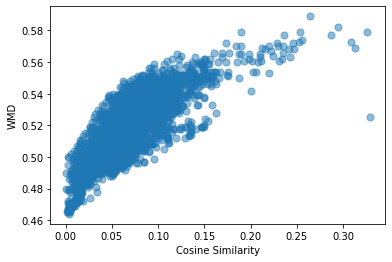

In [10]:
plt.scatter(DF_J_and_C['tfidf_cosine'], DF_J_and_C['WMD'], s=50, alpha=0.5)
plt.xlabel("Cosine Similarity")
plt.ylabel("WMD")

Text(0, 0.5, 'WMD')

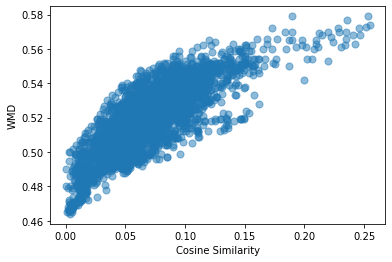

In [11]:
#Eliminamos los puntos que tienen un x > 0.26 y graficamos nuevamente:

# Obtenemos los nombres de los indices donde la columna 'x' sea >=0.26:
indexNames = DF_J_and_C[DF_J_and_C['tfidf_cosine'] >=0.26].index
# Eliminamos estas filas con dichos indices de nuestro DF:
DF_J_and_C.drop(indexNames , inplace=True)

plt.scatter(DF_J_and_C['tfidf_cosine'], DF_J_and_C['WMD'], s=50, alpha=0.5)
plt.xlabel("Cosine Similarity")
plt.ylabel("WMD")

En total eliminamos 7 puntos.

In [12]:
print(DF_J_and_C.shape)

(2993, 4)


### 10-K-means

#### 1ro un ejemplo de kmeans (https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)

In [13]:
#Ver imports:
    #np
    #KMeans
    
#Suponemos X nuestro DF con 2 features para entrenar KNN:
#Por ejemplo 1,1,1,10,10,10 es uno de nuestros features.
             #y 2,4,0,2,4,0 es el otro de nuestros features.
X = np.array([[1, 2], [1, 4], [1, 0],[10, 2], [10, 4], [10, 0]])

#Ahora entrenamos kmeans con 2 clusters (k = 2):
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)

#Y luego de entrenarlo obtenemos nuestros labels (nuestros resultados: a qué k pertenece cada vector
#que definimos arriba en "X")

print(kmeans.labels_)

#Ahora vamos a predecir con nuevos 2 nuevos valores/vectores:
kmeans.predict([[0, 0], [12, 3]])

#Vemos la posición en X e Y de nuestros 2 centroides:
print(kmeans.cluster_centers_)

[1 1 1 0 0 0]
[[10.  2.]
 [ 1.  2.]]


#### Ahora si, a nuestra aplicación concreta:

In [14]:
#X y Y son nuestros FEATURES:
X = np.array(DF_J_and_C["tfidf_cosine"])
Y = np.array(DF_J_and_C['WMD'])

Data = {'x': X,
        'y': Y
       }
  
df = DataFrame(Data,columns=['x','y'])
df

,x,y
0,0.043,0.517
1,0.111,0.525
2,0.018,0.501
3,0.050,0.518
4,0.065,0.515
...,...,...
2988,0.026,0.485
2989,0.106,0.516
2990,0.063,0.512
2991,0.081,0.507


### ELBOW method

* Inertia (Sklearn) =  WCSS. Es la suma de los cuadrados de las distancias de las muestras a su centroide más cercano. 

In [20]:
#pip install --upgrade numpy==1.21.4   #Versión correcta.
inertias = []
K = range(1,10) 

for k in K: 
    #Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(df)
    inertias.append(kmeanModel.inertia_) 

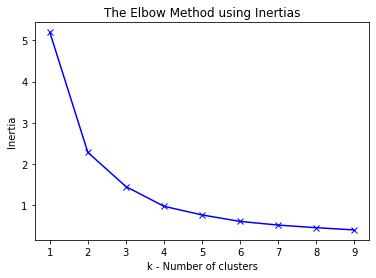

In [21]:
plt.plot(K, inertias, 'bx-') 
plt.xlabel('k - Number of clusters') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertias') 
plt.show()

### ENTRENANDO a nuestro DF con K apropiado.

In [18]:
#Entrenamos Kmeans con todo nuestro DF:
kmeans = KMeans(n_clusters=4,random_state=1,init='k-means++', max_iter=300).fit(df)
centroids = kmeans.cluster_centers_
print(centroids)
print(kmeans.labels_)

[[0.09918866 0.53471991]
 [0.02786646 0.49498447]
 [0.16229825 0.55270175]
 [0.06061035 0.51821994]]
[3 0 1 ... 3 3 3]


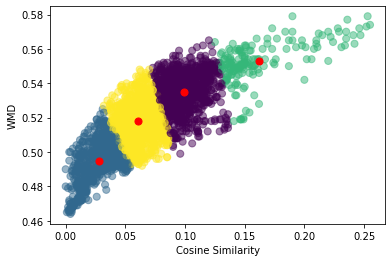

In [19]:
#Ploteamos los centroides de cada grupo:

plt.scatter(df['x'], df['y'], c=kmeans.labels_.astype(float), s=50, alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=50, label = 'centroids')
plt.xlabel("Cosine Similarity")
plt.ylabel("WMD")
plt.show()

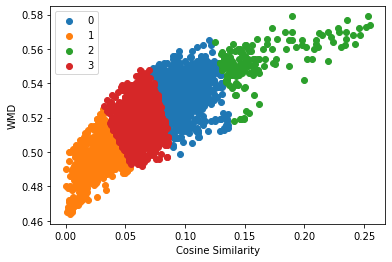

In [20]:
#Ploteamos cada grupo:

fig, ax = plt.subplots()
scatter_x = np.array(DF_J_and_C["tfidf_cosine"])
scatter_y = np.array(DF_J_and_C['WMD'])
group = np.array(kmeans.labels_)
for g in np.unique(group):
    i = np.where(group == g)
    ax.scatter(scatter_x[i], scatter_y[i], label=g)
ax.legend()
plt.xlabel("Cosine Similarity")
plt.ylabel("WMD")
plt.show()

In [21]:
#Añadimos la columna al DF:
new_column =  kmeans.labels_
DF_J_and_C['Result K-means'] = new_column
DF_J_and_C

,Candidate_Name,Job_Title,tfidf_cosine,WMD,Result K-means
0,DataScientist_Karla_Lewis,Data Scientist,0.043,0.517,3
1,DataScientist_Karla_Lewis,Data Scientist 2,0.111,0.525,0
2,DataScientist_Karla_Lewis,HCM Consultant,0.018,0.501,1
3,DataScientist_Karla_Lewis,Machine Learning Engineer,0.050,0.518,3
4,DataScientist_Karla_Lewis,Machine Learning Engineer 2,0.065,0.515,3
...,...,...,...,...,...
2995,Neha Mugghala,Test Lead / Test Manager,0.026,0.485,1
2996,Neha Mugghala,Principal Application Analyst-Supply Chain Lawson,0.106,0.516,0
2997,Neha Mugghala,Messaging Administrator,0.063,0.512,3
2998,Neha Mugghala,"Java Architect - Denver, CO - Fulltime",0.081,0.507,3


#### Creamos nueva columna 'Result K-means final' indicando los nuevos valores de los labels, para ser más claros y ordenar de menor a mayor similitud las comparaciones:
    * Nivel Bajo Similitud:     ('Result K-means' = 0)  -->  ('Result K-means final' = 2)
    * Nivel Medio Similitud:    ('Result K-means' = 2)  -->  ('Result K-means final' = 3)
    * Nivel Alto Similitud:     ('Result K-means' = 3)  -->  ('Result K-means final' = 1)
    * Nivel Muy Alto SImilitud: ('Result K-means' = 1)  -->  ('Result K-means final' = 0)

In [22]:
dic = {0: 2, 3: 1, 2: 3, 1: 0}
DF_J_and_C['Result K-means'].replace(dic, inplace=True)

In [23]:
DF_J_and_C

,Candidate_Name,Job_Title,tfidf_cosine,WMD,Result K-means
0,DataScientist_Karla_Lewis,Data Scientist,0.043,0.517,1
1,DataScientist_Karla_Lewis,Data Scientist 2,0.111,0.525,2
2,DataScientist_Karla_Lewis,HCM Consultant,0.018,0.501,0
3,DataScientist_Karla_Lewis,Machine Learning Engineer,0.050,0.518,1
4,DataScientist_Karla_Lewis,Machine Learning Engineer 2,0.065,0.515,1
...,...,...,...,...,...
2995,Neha Mugghala,Test Lead / Test Manager,0.026,0.485,0
2996,Neha Mugghala,Principal Application Analyst-Supply Chain Lawson,0.106,0.516,2
2997,Neha Mugghala,Messaging Administrator,0.063,0.512,1
2998,Neha Mugghala,"Java Architect - Denver, CO - Fulltime",0.081,0.507,1


#### Visualizamos 20 candidatos con resultado 2 o 3

In [24]:
new_df =  DF_J_and_C[(DF_J_and_C['Result K-means']==2) | (DF_J_and_C['Result K-means']==3)]
new_df.head(20)

,Candidate_Name,Job_Title,tfidf_cosine,WMD,Result K-means
1,DataScientist_Karla_Lewis,Data Scientist 2,0.111,0.525,2
22,DataScientist_Karla_Lewis,Sales Engineer - Los Angles,0.099,0.524,2
31,DataScientist_Rahul_Malik,Data Scientist 2,0.098,0.519,2
52,DataScientist_Rahul_Malik,Sales Engineer - Los Angles,0.083,0.523,2
120,MLEngineer_Bradly_Johnston,Data Scientist,0.160,0.566,3
123,MLEngineer_Bradly_Johnston,Machine Learning Engineer,0.246,0.572,3
129,MLEngineer_Bradly_Johnston,AUTOMATION TEST ENGINEER,0.092,0.556,2
131,MLEngineer_Bradly_Johnston,Business Solutions Architect,0.086,0.543,2
137,MLEngineer_Bradly_Johnston,Front End Developer,0.078,0.538,2
150,MLEngineer_Jonathon_Price,Data Scientist,0.193,0.561,3


In [25]:
#Vemos resultados por ejemplo para 'SecuritySpecialist_Ahmed Wayne':
is_Ahmed_Wayne =  DF_J_and_C['Candidate_Name']=='SecuritySpecialist_Ahmed Wayne'
new_DF = DF_J_and_C[is_Ahmed_Wayne]
print(new_DF.shape)
new_DF

(30, 5)


,Candidate_Name,Job_Title,tfidf_cosine,WMD,Result K-means
180,SecuritySpecialist_Ahmed Wayne,Data Scientist,0.025,0.507,0
181,SecuritySpecialist_Ahmed Wayne,Data Scientist 2,0.046,0.517,1
182,SecuritySpecialist_Ahmed Wayne,HCM Consultant,0.055,0.501,1
183,SecuritySpecialist_Ahmed Wayne,Machine Learning Engineer,0.058,0.527,1
184,SecuritySpecialist_Ahmed Wayne,Machine Learning Engineer 2,0.018,0.511,0
185,SecuritySpecialist_Ahmed Wayne,Security Specialist,0.115,0.551,2
186,SecuritySpecialist_Ahmed Wayne,Security Specialist 2,0.110,0.532,2
187,SecuritySpecialist_Ahmed Wayne,Web Developer Full Stack,0.013,0.499,0
188,SecuritySpecialist_Ahmed Wayne,Web Developer Full Stack 2,0.062,0.524,1
189,SecuritySpecialist_Ahmed Wayne,AUTOMATION TEST ENGINEER,0.040,0.520,1


Observamos altos valores en puestos relacionados a Seguridad y Redes (Algo esperable).

## 11-KNN.

### 11.1-Esquema 1: Train Set, Test Set & Validation Set.

<img src="img/Division_datos_para_KNN.jpg"> 

* Etapa 1- Evaluamos nuestro algoritmo utilizando "Train Set 2" y "Validation Set" para encontrar el hiperparámetro 'k' más adecuado en KNN (el que nos dé el mejor accuracy para las predicciones): elegimos un k=10 donde accuracy=0.9937.
* Etapa 2- Realizamos una evaluación final utilizando "Train Set" y "Test Set" con el K obtenido en 1 para obtener el accuracy final de nuestro modelo. Nos dió un accuracy = 0.98998. 
* Etapa 3- Realizamos una predicción final utilizando los datos "Prediction Final Set". 

In [26]:
#Esto sería nuestro "Base Set":

#En X colocamos únicamente las features numéricas 'tfidf_cosine' y 'WMD' para predecir la variable Y.
x_data = DF_J_and_C.drop(["Candidate_Name","Job_Title","Result K-means"],axis=1)

#En Y colocaremos nuestra variable a predecir / nuestro "target", 'Result K-means':
y = DF_J_and_C['Result K-means']

In [27]:
x_data

,tfidf_cosine,WMD
0,0.043,0.517
1,0.111,0.525
2,0.018,0.501
3,0.050,0.518
4,0.065,0.515
...,...,...
2995,0.026,0.485
2996,0.106,0.516
2997,0.063,0.512
2998,0.081,0.507


In [28]:
y

0       1
1       2
2       0
3       1
4       1
       ..
2995    0
2996    2
2997    1
2998    1
2999    1
Name: Result K-means, Length: 2993, dtype: int32

In [29]:
#Ver imports: train_test_split, KNeighborsClassifier, metrics.

#Esto sería nuestro 'Train Set' y 'Test Set':    
#Entrenamiento... separamos 20% test y 80% para entrenamiento:
X_train,X_test,y_train,y_test = train_test_split(x_data,y,test_size=0.2,random_state=4)

#Esto sería nuestro 'Train Set 2' y 'Validation Set' (que creamos a partir de 'Train Set'):
X_train_2,X_validation,y_train_2,y_validation = train_test_split(X_train,y_train,test_size=0.2,random_state=4)

In [30]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print('-------------------')
print(X_train_2.shape)
print(y_train_2.shape)
print(X_validation.shape)
print(y_validation.shape)

(2394, 2)
(599, 2)
(2394,)
(599,)
-------------------
(1915, 2)
(1915,)
(479, 2)
(479,)


##### Etapa 1

In [31]:
#Para estimar el rendimiento de un modelo de ML:
#1-Alimentamos los datos de entrenamiento a nuestro algoritmo de aprendizaje para aprender un modelo. 
#2-Predecimos las etiquetas de nuestro conjunto de prueba.
#3-Contamos el número de predicciones incorrectas en el conjunto de datos de prueba para calcular la precisión de predicción del modelo.

#Dependiendo del valor de K el algoritmo se comporta de mejor o peor manera. 
#Vamos a realizar un barrido para los distintos valores de K (del 1 al 50).
#Y así, para cada uno de estos valores de K vamos a entrenar al algoritmo y así vamos a obtener la exactitud/score del algoritmo:

k_range = range(1,51) #Valores de K (1-50)
scores = {}
scores_list = []
for k in k_range:
        knn = KNeighborsClassifier(n_neighbors=k,metric='euclidean') #Llamamos al modelo de clasificación (KNN) y le pasamos cada valor de K. 
        #1-Alimentamos los datos de entrenamiento a nuestro algoritmo de aprendizaje para aprender un modelo:
        knn.fit(X_train_2,y_train_2) #Se va a entrenar al algorimo para ese K con los x_train e Y_train que elegimos previamente.
        #2-Predecimos las etiquetas de nuestro conjunto de prueba.
        y_pred=knn.predict(X_validation) #Y ahora hacemos una predicción con los X_Test.
        #3-Contamos el número de predicciones incorrectas en el conjunto de datos de prueba para calcular la precisión de predicción del modelo.
        scores[k] = metrics.accuracy_score(y_validation,y_pred) #Después calculamos y guardamos el score de esa predicción con ese valor de K.
        #De esta manera, si y_test es = a y_pred, el accuracy será 1, y si son distintos, será 0. 
        #Luego sumará todos estos resultados y se dividirá por el número total de predicciones realizadas.
        #Esto nos dará un porcentaje de cuantas veces clasificamos correctamente.
        scores_list.append(scores[k]) #Y esa predicción la metemos en una lista.

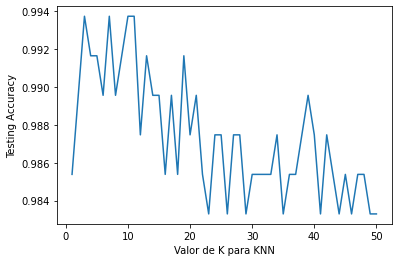

In [32]:
#Ahora graficamos y vemos la relación entre los K y la exactitud/score del algoritmo:
plt.plot(k_range,scores_list)
plt.xlabel('Valor de K para KNN')
plt.ylabel('Testing Accuracy')
plt.show()

In [33]:
print('%.4f'%(scores[10])) #Score para k=10 (truncamos a 4 valores despues de la coma)

0.9937


##### Etapa 2

### Entrenamos KNN con un K óptimo (K=10)

In [34]:
k_Optimo=10
knn = KNeighborsClassifier(n_neighbors=k_Optimo, metric='euclidean') #Le asignamos este k=10.
knn.fit(X_train,y_train) #Se va a entrenar al algorimo para ese k=10 con los x_train e Y_train que elegimos previamente.
y_pred=knn.predict(X_test) #Y ahora hacemos una predicción con los X_Test.
score = metrics.accuracy_score(y_test,y_pred) #Cálculo del score para k=10.

print("Precisión de KNN con K optimo:",('%.5f'%(score))) #printeamos el score.

Precisión de KNN con K optimo: 0.98998


Observamos que esta predicción es 0,001 menor a la predicción anterior con los datos de entrenamiento, pero sin embargo es un muy buen valor de accuracy.

In [35]:
pickle.dump(knn, open('Modelo_KNN_esquema_1.sav', 'wb')) #Guardamos el modelo localmente.

##### Etapa 3

Esta etapa no fue realizada para este esquema dado que el esquema 2 utilizando Cross Validation ofrece ventajas con respecto al esquema 1 (las cuales estan descriptas en el informe). Es por esto que directamente la Etapa 3 se realizó para el esquema 2 (en la sección '12-Clasificando nuevas muestras.').

### 11.2-Esquema 2: Cross Validation.

<img src="img/KNN_with_cross_validation.jpg"> 

* Etapa 1- Evaluamos nuestro algoritmo utilizando únicamente el 'Train Set' mediante Cross Validation (el Set de test es 'dinámico' y vive dentro de este 'Train Set'). De esta manera encontramos el hiperparámetro 'k' más adecuado en KNN (el que nos dé el mejor accuracy para las predicciones): elegimos un k=8 donde accuracy= 0.9937.
* Etapa 2- Realizamos una evaluación final utilizando "Train Set" y "Test Set" con el K obtenido en 1 para obtener el accuracy final de nuestro modelo. Nos dió un accuracy = 0.98998. 
* Etapa 3- Realizamos una predicción final utilizando los datos "Prediction Final Set".

##### Etapa 1

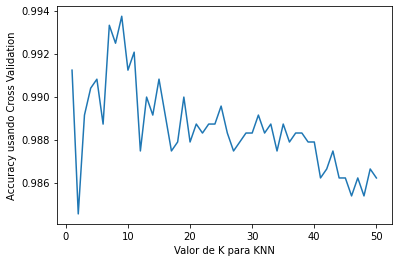

In [36]:
#Ver imports: cross_val_score y plt.

#Para estimar el rendimiento de un modelo de ML:
#1-Alimentamos los datos de entrenamiento a nuestro algoritmo de aprendizaje para aprender un modelo. 
#2-Predecimos las etiquetas de nuestro conjunto de prueba.
#3-Contamos el número de predicciones incorrectas en el conjunto de datos de prueba para calcular la precisión de predicción del modelo.

k_range = range(1,51) #Valores de K (1-50)
k_scores = []
# Iteramos para calcular los diferentes k, luego retornamos el PROMEDIO de accuracy basado en cross validation.
for k in k_range:   #ciclo for para los k=50 de hiper-parámetros.
    knn = KNeighborsClassifier(n_neighbors=k,metric='euclidean') 
    #1,2,3 se hace todo acá:
    scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')   #ciclo para los k=5 de Cross validation.
    k_scores.append(scores.mean())
    
plt.plot(k_range, k_scores)
plt.xlabel('Valor de K para KNN')
plt.ylabel('Accuracy usando Cross Validation')
plt.show()

In [37]:
print('%.4f'%(k_scores[8])) #Score para k=8 (truncamos a 4 valores despues de la coma)

0.9937


Vemos que entre 6 y 10 son buenos valores de K, luego el accuracy del modelo cae debido al underfitting.

##### Etapa 2

### Entrenamos KNN con un K óptimo (K=8)

In [38]:
#Etapa 2- Realizamos una evaluación final utilizando "Train Set" y "Test Set" con el K obtenido en 1 para obtener el accuracy final de nuestro modelo. Nos dió un accuracy = 0.995. 

k_Optimo=8
knn = KNeighborsClassifier(n_neighbors=k_Optimo, metric='euclidean') 
knn.fit(X_train,y_train) 
y_pred=knn.predict(X_test)
score = metrics.accuracy_score(y_test,y_pred) 

print("Precisión de KNN con K optimo:",('%.5f'%(score)))

Precisión de KNN con K optimo: 0.98998


Observamos que esta predicción es un poco menor a la predicción anterior con los datos de entrenamiento (0.9937), pero sin embargo es un muy buen valor de accuracy.

In [39]:
pickle.dump(knn, open('Modelo_KNN_esquema_2_Cross_Validation.sav', 'wb')) #Guardamos el modelo localmente.

##### Etapa 3

## 12-Clasificando nuevas muestras.

Ya teniendo nuestro modelo de KNN entrenado (utilizando Cross Validation al realizar la evaluación de nuestro modelo), ahora vamos a predecir con este modelo para un nuevo Candidato y una nueva Posición. En esta predicción se clasificarán las nuevas muestras de acuerdo a las 4 categorías que creamos con k-means.

De esta manera obtendremos:
* Las predicciones del Candidato 'SecuritySpecialist_Denis Banik' para todas las posiciones del DF; y
* las predicciones de la Posición 'HCM Consultant 2" para todos los candidatos del DF.

In [40]:
# Etapa 3- Realizamos una predicción final utilizando los datos "Prediction Final Set". 
knn_model_loaded = pickle.load(open('Modelo_KNN_esquema_2_Cross_Validation.sav', 'rb')) #Cargamos el modelo que guardamos previamente con pickle.

### 12.1-Candidato 'SecuritySpecialist_Denis Banik'.

In [41]:
#Al agregar un nuevo candidato (aplica al puesto) se calcula el WMD y Cosine y se PREDICE con este modelo de KNN. 

x_predict_Denis_Banik = DF_Denis_Banik.drop(["Candidate_Name","Job_Title"],axis=1)
x_predict_Denis_Banik

,tfidf_cosine,WMD
217,0.019,0.508
218,0.022,0.505
219,0.030,0.497
220,0.047,0.510
221,0.041,0.524
222,0.021,0.518
223,0.171,0.544
224,0.131,0.526
225,0.010,0.504
226,0.029,0.507


In [42]:
y_pred=knn.predict(x_predict_Denis_Banik)
y_pred

array([0, 0, 0, 1, 1, 0, 3, 2, 0, 0, 0, 3, 0, 0, 0, 0, 1, 0, 0, 0, 1, 3,
       0, 0, 0, 1, 0, 1, 1, 0, 0], dtype=int32)

In [43]:
len(y_pred)

31

In [44]:
#Añadimos la columna al DF:
new_column =  y_pred
DF_Denis_Banik['Result KNN'] = new_column
DF_Denis_Banik

<ipython-input-44-b3de3c481708>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DF_Denis_Banik['Result KNN'] = new_column


,Candidate_Name,Job_Title,tfidf_cosine,WMD,Result KNN
217,SecuritySpecialist_Denis Banik,Data Scientist,0.019,0.508,0
218,SecuritySpecialist_Denis Banik,Data Scientist 2,0.022,0.505,0
219,SecuritySpecialist_Denis Banik,HCM Consultant,0.030,0.497,0
220,SecuritySpecialist_Denis Banik,HCM Consultant 2,0.047,0.510,1
221,SecuritySpecialist_Denis Banik,Machine Learning Engineer,0.041,0.524,1
222,SecuritySpecialist_Denis Banik,Machine Learning Engineer 2,0.021,0.518,0
223,SecuritySpecialist_Denis Banik,Security Specialist,0.171,0.544,3
224,SecuritySpecialist_Denis Banik,Security Specialist 2,0.131,0.526,2
225,SecuritySpecialist_Denis Banik,Web Developer Full Stack,0.010,0.504,0
226,SecuritySpecialist_Denis Banik,Web Developer Full Stack 2,0.029,0.507,0


### 12.2-Posición 'HCM Consultant 2'.

In [45]:
x_predict_HCM_C_2 = DF_HCM_C_2.drop(["Candidate_Name","Job_Title"],axis=1)
x_predict_HCM_C_2

,tfidf_cosine,WMD
3,0.013,0.500
34,0.003,0.491
65,0.272,0.544
96,0.055,0.528
127,0.039,0.513
...,...,...
2979,0.102,0.524
3010,0.059,0.507
3041,0.054,0.506
3072,0.240,0.573


In [46]:
#x_predict_HCM_C_2

y_pred=knn.predict(x_predict_HCM_C_2)
y_pred

array([0, 0, 3, 1, 0, 1, 1, 1, 0, 1, 1, 1, 3, 3, 3, 2, 2, 1, 2, 3, 2, 1,
       1, 3, 0, 3, 1, 2, 2, 2, 3, 2, 3, 2, 2, 3, 1, 1, 3, 2, 2, 2, 1, 2,
       2, 1, 2, 2, 1, 2, 1, 3, 1, 2, 1, 3, 1, 2, 1, 1, 1, 1, 1, 0, 1, 3,
       0, 2, 2, 2, 1, 2, 2, 1, 3, 1, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 0, 2, 2, 2, 2, 1, 2, 1, 1, 3, 1], dtype=int32)

In [47]:
len(y_pred)

101

In [48]:
#Añadimos la columna al DF:
new_column =  y_pred
DF_HCM_C_2['Result KNN'] = new_column
DF_HCM_C_2.head(10)

<ipython-input-48-601f64783df9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DF_HCM_C_2['Result KNN'] = new_column


,Candidate_Name,Job_Title,tfidf_cosine,WMD,Result KNN
3,DataScientist_Karla_Lewis,HCM Consultant 2,0.013,0.500,0
34,DataScientist_Rahul_Malik,HCM Consultant 2,0.003,0.491,0
65,HCM_Federico_Calonge,HCM Consultant 2,0.272,0.544,3
96,HCM_Robert_Smith,HCM Consultant 2,0.055,0.528,1
127,MLEngineer_Bradly_Johnston,HCM Consultant 2,0.039,0.513,0
158,MLEngineer_Jonathon_Price,HCM Consultant 2,0.052,0.512,1
189,SecuritySpecialist_Ahmed Wayne,HCM Consultant 2,0.064,0.521,1
220,SecuritySpecialist_Denis Banik,HCM Consultant 2,0.047,0.510,1
251,WebDev_Alec_Dionisio,HCM Consultant 2,0.042,0.507,0
282,WebDev_Karen_Higgins,HCM Consultant 2,0.044,0.515,1


### En conclusión me dieron resultados esperables las predicciones de nuevas muestras.
* Para el Candidato 'SecuritySpecialist_Denis Banik' obtuvimos altos valores de predicción (columna 'Result KNN') para puestos relacionados a Seguridad (Algo esperable).
* Para la Posición 'HCM Consultant 2' obtuvimos un alto nivel de predicción (columna 'Result KNN') para el candidato 'HCM_Federico_Calonge' (Algo esperable).  